In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
# data_path = './data/' # default sim data from Udacity
# data_path = '../Simulator/' # my sim data
data_path = './training_data/' # AWS sim data
img_path = data_path+'IMG/'
csv_file = data_path+'driving_log.csv'

In [ ]:
np.exp

In [46]:
k = 3.0 # [normalized +/-1.0] (+) right
b = 0.2

images=[]
measurements = []

with open(csv_file) as f:
    reader = csv.reader(f)
    next(reader) # skip 1st line
    for line in reader:
        steering_angle = float(line[3])
        steer_corr_left = k*(np.exp(steering_angle)-1)+b
        steer_corr_right= k*(np.exp(-steering_angle)-1)+b
        
        # center channel
        #if(np.abs(steering_angle)>0.1): # Jendrik suggested this. I'm not so sure...
        if(True):
            file_center = img_path + line[0].split('/')[-1]
            img_center = cv2.imread(file_center, cv2.COLOR_BGR2RGB)
            images.append(img_center)

            measurements.append(steering_angle)

        # left channel
#         if(np.random.random()<.2):
        if(True):
            file_left = img_path + line[1].split('/')[-1]
            img_left = cv2.imread(file_left, cv2.COLOR_BGR2RGB)
            images.append(img_left)

            steering_left = steering_angle + steer_corr_left #steering angle
            steering_left = max(min(steering_left, 1.0), -1.0)
            measurements.append(steering_left)

        # right channel
#         if(np.random.random()<.2):
        if(True):
            file_right = img_path + line[2].split('/')[-1]
            img_right = cv2.imread(file_right, cv2.COLOR_BGR2RGB)
            images.append(img_right)

            steering_right = steering_angle - steer_corr_right #steering angle
            steering_right = max(min(steering_right, 1.0), -1.0)
            measurements.append(steering_right)

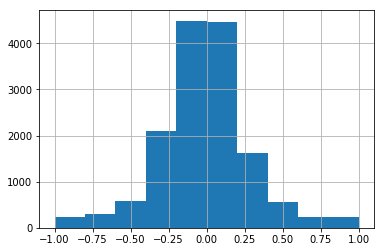

In [47]:
plt.hist(measurements)
plt.grid()
plt.show()


## NEED TO ADD GENERATOR!!!!

In [50]:
X_train = np.array(images)
y_train = np.array(measurements)

# generate flipped image data
X_train_flip = np.array(np.fliplr(images))
y_train_flip = -np.array(measurements)

X_train = np.concatenate((X_train, X_train_flip), axis=0)
y_train = np.concatenate((y_train, y_train_flip), axis=0)

MemoryError: 

In [42]:
# train model  
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, MaxPooling2D, Dropout, Cropping2D
from keras.layers.convolutional import Conv2D

imshape = X_train[0].shape

model = Sequential()
model.add(Lambda(lambda x: ((x/255.0)-0.5),
                 input_shape=imshape,
                 name='lambda'))
model.add(Cropping2D(cropping=((50,20),(0,0)),
                     name='crop'))
model.add(Conv2D(nb_filter=24,
                 nb_row=5,
                 nb_col=5,
                 subsample=(2,2),
                 border_mode='valid',
                 activation='elu',
                 name='conv1'))
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(nb_filter=36,
                 nb_row=5,
                 nb_col=5,
                 subsample=(2,2),
                 border_mode='valid',
                 activation='elu',
                 name='conv2'))
model.add(Conv2D(nb_filter=48,
                 nb_row=5,
                 nb_col=5,
                 subsample=(2,2),
                 border_mode='valid',
                 activation='elu',
                 name='conv3'))
model.add(Conv2D(nb_filter=64,
                 nb_row=3,
                 nb_col=3,
                 subsample=(1,1),
                 border_mode='valid',
                 activation='elu',
                 name='conv4'))
model.add(Conv2D(nb_filter=64,
                 nb_row=3,
                 nb_col=3,
                 subsample=(1,1),
                 border_mode='valid',
                 activation='elu',
                 name='conv5'))
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten(name='flat'))
model.add(Dropout(0.5, name='dropout'))
model.add(Dense(100, activation='elu', name='dense1'))
model.add(Dense(50, activation='elu', name='dense2'))
model.add(Dense(10, activation='elu', name='dense3'))
model.add(Dense(1, name='output'))

In [43]:
from functools import reduce
def prod(input):
    return reduce(lambda x, y: x*y, input, 1)

In [44]:
print('Layer input shapes:')
for layer in model.layers:
    shape = layer.get_input_shape_at(0)
    print(layer.name, shape, ' = '+str(prod(shape[1:]))+' neurons', sep='\t')

Layer input shapes:
lambda	(None, 160, 320, 3)	 = 153600 neurons
crop	(None, 160, 320, 3)	 = 153600 neurons
conv1	(None, 90, 320, 3)	 = 86400 neurons
conv2	(None, 43, 158, 24)	 = 163056 neurons
conv3	(None, 20, 77, 36)	 = 55440 neurons
conv4	(None, 8, 37, 48)	 = 14208 neurons
conv5	(None, 6, 35, 64)	 = 13440 neurons
flat	(None, 4, 33, 64)	 = 8448 neurons
dropout	(None, 8448)	 = 8448 neurons
dense1	(None, 8448)	 = 8448 neurons
dense2	(None, 100)	 = 100 neurons
dense3	(None, 50)	 = 50 neurons
output	(None, 10)	 = 10 neurons


In [45]:
model.compile(loss='mse',
              optimizer='adam')
history_obj = model.fit(X_train, y_train,
                        validation_split=0.2,
                        shuffle=True,
                        nb_epoch=3,
                        batch_size=64)
model.save('model.h5')

Train on 23697 samples, validate on 5925 samples
Epoch 1/3
23697/23697 [==============================] - 62s - loss: 0.0215 - val_loss: 0.0244

In [36]:
### print the keys contained in the history object
print('History object keys:')
print(history_obj.history.keys())

History object keys:
dict_keys(['val_loss', 'loss'])


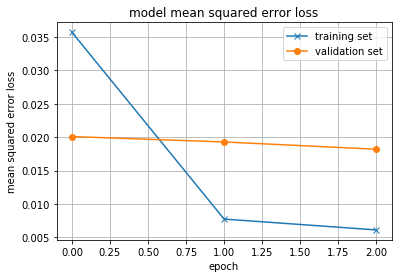

In [37]:
### plot the training and validation loss for each epoch
plt.plot(history_obj.history['loss'],'x-')
plt.plot(history_obj.history['val_loss'],'o-')
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.grid()
plt.show()